In [1]:
import aquamonitor as am
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Estimating riverine fluxes

For a project with Miljødirektoratet, Øyvind needs to estimate daily riverine fluxes for 2020 for three rivers: Tana, Målselva and Glomma. This is a good opportunity to test integration of three components of the JupyterHub: the Aquamonitor API, the NVE API and the functions in NivaPy for flux estimation. 

## 1. Water chemistry from Aquamonitor

The first step is to query water chemistry data from Aquamonitor.

In [2]:
# Login to am
token = am.login()

Please enter your credentials.


Username:  ···
Password:  ··············


In [3]:
# List project like Elvervåkingsprogrammet
proj_df = am.get_projects(token=token)
proj_df.query("ProjectName.str.contains('Elveover')", engine="python")

,ProjectId,ProjectCode,ProjectName,Description
1000,10306,16384-3,Elveovervåkingsprogrammet,Etterfølgeren til RID. Overvåking av tilførsle...
1040,11126,16384-4,Elveoverv opsj3 2017,Opsjon 3 vannkjemisk overvåking utv elver i 2017
1088,11927,16384-4,Elveoverv opsj3 2018,Opsjon 3 vannkjemisk overvåking utv elver i 2018
1149,12370,16384-19,Elveoverv_Flomprøver,Flomprøver på Elveoverv
1162,12388,NaN,Elveovervåkingen 2017,NaN
1169,12399,16384,Elveovervåkningen Miljøgifter 2018,Miljøgifter fisk Elveovervåkningen 2018
1171,12402,"16384-4,190018",Elveoverv opsj3 2019,Opsjon 3 vannkjemisk overvåking utv elver i 2019
1199,12432,16384,Elveovervåkningen miljøgifter 2019-2020,"Alna, Miljøgifter"
1236,12475,NaN,Elveovervåking biologi 2018,NaN
1237,12476,NaN,Elveovervåkingen 2018,Alle stasjoner for Elveovervåkingen 2018


In [4]:
# Get stations associated 2017 - 2020
proj_id = 10306

stn_df = am.get_project_stations(proj_id, token=token)
print(f"{len(stn_df)} stations in project.")
stn_df

22 stations in project.


,ProjectId,StationId,StationCode,StationName,Type
0,10306,40352,BUSEDRA,Drammenselva,Elv
1,10306,40353,TELESKI,Skienselva,Elv
2,10306,40354,VAGEOTR,Otra,Elv
3,10306,40355,VESENUM,Numedalslågen,Elv
4,10306,40356,ØSTEGLO,Glomma ved Sarpsfoss,Elv
5,10306,40357,STREORK,Orkla,Elv
6,10306,40358,FINEALT,Altaelva,Elv
7,10306,40360,NOREVEF,Vefsna,Elv
8,10306,40361,ROGEORR,Orreelva,Elv
9,10306,40365,STRENID,Nidelva(Tr.heim),Elv


Øyvind is interested in Glomma ved Sarpsfoss, Målselva v/gml E6-brua and Tanaelva, which have station IDs 40356, 69594 and 40373, respectively.

In [5]:
# Get chemistry data for 2020
st_dt = "01.01.2020"
end_dt = "31.12.2020"
wc_df = am.get_project_chemistry(proj_id, st_dt, end_dt, token=token)

# Subset to stations of interest
stn_list = [40356, 69594, 40373]
wc_df = wc_df.query("StationId in @stn_list")

# Subset to parameters of interest
par_list = [
    "Ag",
    "As",
    "Ca",
    "Cd",
    "Cd-filt",
    "Cr",
    "Cu",
    "DOC",
    "Fluoren",
    "Hg",
    "Hg-filt",
    "NH4-N",
    "NO3+NO2-N",
    "NO3-N",
    "Ni",
    "Ni-filt",
    "PO4-P",
    "POC",
    "Pb",
    "Pb-filt",
    "STS",
    "Si",
    "SiO2",
    "TOC",
    "TOTN",
    "TOTP",
    "TSM",
    "Zn",
]
wc_df = wc_df.query("ParameterName in @par_list")

# Tidy/standardise units in response from AM
wc_df["Unit"].replace(
    {
        "mg/L": "mg/l",
        "µg/L": "ug/l",
        "ng/L": "ng/l",
        "mg/L C": "mg/l",
        "µg/l C": "ug/l",
        "µg/l N": "ug/l",
        "µg/l P": "ug/l",
    },
    inplace=True,
)

# Tidy column names
assert (wc_df["Depth1"] == 0).all()
assert (wc_df["Depth2"] == 0).all()
wc_df["par_unit"] = wc_df["ParameterName"] + "_" + wc_df["Unit"]
wc_df.drop(
    ["ProjectId", "ProjectName", "Depth1", "Depth2", "ParameterName", "Unit", "Flag"],
    axis="columns",
    inplace=True,
)
wc_df.rename(
    {
        "StationId": "station_id",
        "StationCode": "station_code",
        "StationName": "station_name",
        "SampleDate": "sample_date",
        "Value": "value",
    },
    axis="columns",
    inplace=True,
)
cols = [
    "station_id",
    "station_code",
    "station_name",
    "sample_date",
    "par_unit",
    "value",
]
wc_df = wc_df[cols]

# Reshape to wide
wc_df.set_index(
    ["station_id", "station_code", "station_name", "sample_date", "par_unit"],
    inplace=True,
)
wc_df = wc_df.unstack("par_unit")
wc_df.columns = wc_df.columns.get_level_values(1)
wc_df.reset_index(inplace=True)

wc_df.head()

par_unit,station_id,station_code,station_name,sample_date,Ag_ug/l,As_µg/l,Ca_mg/l,Cd-filt_µg/l,Cd_µg/l,Cr_µg/l,...,Pb-filt_µg/l,Pb_ug/l,STS_mg/l,SiO2_mg/l,Si_mg/l,TOC_mg/l,TOTN_µg/l,TOTP_µg/l,TSM_mg/l,Zn_µg/l
0,40356,ØSTEGLO,Glomma ved Sarpsfoss,2020-01-13 07:10:00+00:00,NaN,NaN,5.53,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.21,5.3,800.0,42.0,13.30,NaN
1,40356,ØSTEGLO,Glomma ved Sarpsfoss,2020-02-10 07:15:00+00:00,0.0052,0.35,5.66,NaN,0.0048,1.10,...,NaN,0.360,NaN,NaN,3.01,5.5,740.0,66.0,44.90,2.7
2,40356,ØSTEGLO,Glomma ved Sarpsfoss,2020-03-02 17:30:00+00:00,NaN,NaN,5.23,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.22,5.1,630.0,19.0,14.10,NaN
3,40356,ØSTEGLO,Glomma ved Sarpsfoss,2020-04-14 17:40:00+00:00,NaN,NaN,5.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.93,4.2,650.0,11.0,5.34,NaN
4,40356,ØSTEGLO,Glomma ved Sarpsfoss,2020-05-11 05:15:00+00:00,0.0020,0.15,4.89,NaN,0.0097,0.17,...,NaN,0.142,NaN,NaN,1.56,4.2,780.0,9.0,3.93,2.6


## 2. Get discharge from NVE

In [6]:
# List available NVE parameters
par_df = nivapy.da.get_nve_hydapi_parameters()
par_df

,parameter,parameterName,parameterNameEng,unit
0,0,Nedbør,Precipitation,mm
1,1000,Vannstand,Stage,m
2,1001,Vannføring,Discharge,m³/s
3,1002,Vannhastighet,Water speed,m/s
4,1003,Vanntemperatur,Water temperature,°C
5,1004,Magasinvolum,Reservoir volume,millioner m³
6,1006,Ledningsevne,Conductivity,µS/cm
7,1215,Turbiditet (Nepheometrisk),Turbidity (Nephelometric),NTU
8,14,Vindretning,Wind direction,°
9,15,Vindhastighet,Wind speed,m/s


Note that discharge is parameter ID `1001`.

In [7]:
# List all NVE stations
stn_df = nivapy.da.get_nve_hydapi_stations()
print(len(stn_df), "stations available.")
stn_df.head()

1744 stations available.


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
0,1.15.0,Femsjø,59.13015,11.48516,298887,6559841,81,Haldenvassdraget,3001,Halden,...,NaN,NaN,NaN,NaN,79.5551,79.6937,79.8507,80.0226,80.2810,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1,1.198.0,Berg,59.92993,11.40768,299271,6649056,177,Riserelva,3026,Aurskog-Høland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannstand', 'parameter': 1..."
2,1.200.0,Lierelv,59.92038,11.53180,306146,6647624,134,Haldenvassdraget,3026,Aurskog-Høland,...,35.3131,36.5231,37.1222,37.4959,2.2503,2.3432,2.3588,2.3664,2.3711,"[{'parameterName': 'Vannstand', 'parameter': 1..."
3,1.42.0,Øymarksjø,59.33290,11.63712,308715,6581952,109,Haldenvassdraget,3012,Aremark,...,NaN,NaN,NaN,NaN,108.7342,108.9565,109.1500,109.3411,109.5966,"[{'parameterName': 'Vannstand', 'parameter': 1..."
4,1.43.0,Aspern og Ara,59.14667,11.69273,310848,6561073,106,Haldenvassdraget,3012,Aremark,...,NaN,NaN,NaN,NaN,106.0558,106.1325,106.2793,106.4680,106.8086,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [8]:
# Map all stations
nivapy.spatial.quickmap(
    stn_df, cluster=True, kartverket=True, aerial_imagery=True, popup="station_id"
)

Based on the e-mail from Øyvind, we are interested in stations `2.605.0` (Glomma), `196.35.0` (Målselva) and `234.18.0` (Tanaelva).

In [9]:
# Checks stations are as expected
stn_list = ["2.605.0", "196.35.0", "234.18.0"]
stn_df.query("station_id in @stn_list")

,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
684,196.35.0,Målselvfossen,69.03493,18.65834,646006,7662611,33,Målselvvassdraget,5418,Målselv,...,673.6,748.0,821.0,928.0,3.68,3.92,4.06,4.20,4.38,"[{'parameterName': 'Vannstand', 'parameter': 1..."
850,2.605.0,Solbergfoss,59.63733,11.15354,283189,6617306,98,Glommavassdraget,3014,Indre Østfold,...,2677.0,3046.0,3217.0,3492.0,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."
1077,234.18.0,Polmak nye,70.07034,28.01601,991883,7826523,17,Tana,5441,Tana,...,2200.0,2600.0,3000.0,3500.0,4.77,5.47,6.02,6.54,7.15,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [10]:
# Get discharge data
par_ids = [1001]
st_dt = "2020-01-01"
end_dt = "2021-01-01"
q_df = nivapy.da.query_nve_hydapi(stn_list, par_ids, st_dt, end_dt)

# Convert NVE IDs to AM IDs
q_df["station_id"].replace(
    {
        "2.605.0": 40356,  # Glomma
        "196.35.0": 69594,  # Målselva
        "234.18.0": 40373,  # Tanaelva'
    },
    inplace=True,
)

q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,69594,Målselvfossen,1001,Vannføring,Discharge,Mean,2020-01-01 11:00:00+00:00,25.03098,m³/s,0,3
1,69594,Målselvfossen,1001,Vannføring,Discharge,Mean,2020-01-02 11:00:00+00:00,27.29521,m³/s,0,3
2,69594,Målselvfossen,1001,Vannføring,Discharge,Mean,2020-01-03 11:00:00+00:00,39.39231,m³/s,0,3
3,69594,Målselvfossen,1001,Vannføring,Discharge,Mean,2020-01-04 11:00:00+00:00,38.40289,m³/s,0,3
4,69594,Målselvfossen,1001,Vannføring,Discharge,Mean,2020-01-05 11:00:00+00:00,32.08726,m³/s,0,3


Note the `correction` and `quality` columns, which have the following interpretations (from [here](https://hydapi.nve.no/UserDocumentation/#observationsget)).

For the **correction** column:

* 0: No changes
* 1: Manual- or ice correction
* 2: Interpolation
* 3: Value computed with models or/and other series
* 4: Daily mean computed with arithmetic mean. (Only used on series where we normally should use discharge curve)
* 5: Smooth negative value. (Only used with inflow)
* 6: Dry pipe. (Only used with groundwater data)
* 7: Ice in pipe. (Only used with groundwater data)
* 8: Damaged pipe. (Only used with groundwater data)
* 9: Pumping. (Only used with groundwater data)
* 11: Start/end value linear adjustment
* 12: Incomplete data source
* 13: The value is calculated based on a similar station or a station close by. The value is adjusted according to the statistical differences between the original station and the replacement station
* 14: The value is missing, and is only calculated based on statistical information for the data series.
* 15: The value is the result of a calculation that ended in Nan(not a number) or +/-Inf. (Technically, the value needs to be outside the interval -1e+300 to +1e0399.)
* 16: Value fetched from rejected period.

For the **quality** column:

* 0: Unknown
* 1: Uncontrolled
* 2: Primary Controlled
* 3: Secondary Controlled

In [11]:
print("Corrections applied to this dataset:")
print(q_df["correction"].unique())
print()
print("Quality flags for this dataset:")
print(q_df["quality"].unique())

Corrections applied to this dataset:
[0 1 2]

Quality flags for this dataset:
[3 2]


So not all of the data has completed the quality control process, but it's nearly there. Øyvind is happy to use the data as-is for this project.

## 3. Estimate daily fluxes

NivaPy provides several methods for estimating fluxes. These are described in the "docstring" for the main function, shown below.

In this case, Øyvind would like to estimate daily fluxes, so the only two applicable methods are `linear_interpolation` and `log_log_linear_regression`. After some testing, the log-log regression option has very low R-squared (i.e. the relationships between discharge and flow are poor). I will therefore use the simpler option of linear interpolation, although the results are still likely to be uncertain.

In [12]:
nivapy.stats.estimate_fluxes?

Signature:
nivapy.stats.estimate_fluxes(
    q_df,
    chem_df,
    base_freq='D',
    agg_freq='A',
    method='linear_interpolation',
    st_date=None,
    end_date=None,
    plot_fold=None,
)
Docstring:
Takes dataframes of discharge (in m3/s) and water chemistry (in units of mg/l, ug/l and/or ng/l) and estimates
river fluxes (also known as loads). The API is rather limited at present, and should be improved. Currently
implements the following methods of flux estimation:

    - linear_interpolation. chem_df is resampled to the same base frequency as q_df and any data gaps are patched
      by linear interpolation. Fluxes are then calculated for each time step at the base frequency and summed to
      the desired aggregation frequency. Simple, but biased unless you have fairly high-frequency,
      regular sampling of water chemistry

    - simple_means. chem_df and q_df are resampled to the specified aggregation frequency by taking means.
      Fluxes for each aggregated timestep are

In [13]:
# Estimate fluxes
base_freq = "D"
agg_freq = "D"
method = "linear_interpolation"
min_vals = 10  # Min number of data points for calculating fluxes

# Loop over stations
df_list = []
for stn_id in wc_df["station_id"].unique():
    # Get chem and tidy
    stn_wc_df = wc_df.query("station_id == @stn_id").copy()
    stn_wc_df.drop(
        ["station_id", "station_code", "station_name"], axis="columns", inplace=True
    )
    stn_wc_df.set_index("sample_date", inplace=True)

    # Remove columns with very little data
    for col in stn_wc_df.columns:
        if pd.notna(stn_wc_df[col]).sum() < min_vals:
            del stn_wc_df[col]

    # Get chem and flow
    stn_q_df = q_df.query("station_id == @stn_id").copy()
    stn_q_df.set_index("datetime", inplace=True)
    stn_q_df = stn_q_df[["value"]]
    stn_q_df.columns = ["flow_m3/s"]

    # Estimate fluxes
    flux_df = nivapy.stats.estimate_fluxes(
        stn_q_df,
        stn_wc_df,
        base_freq=base_freq,
        agg_freq=agg_freq,
        method=method,
    )

    flux_df["station_id"] = stn_id
    flux_df.reset_index(inplace=True)

    df_list.append(flux_df)

# Combine and add station code
flux_df = pd.concat(df_list, axis="rows")
flux_df = pd.merge(
    flux_df,
    wc_df[["station_id", "station_code"]].drop_duplicates(),
    how="left",
    on="station_id",
)

# Tidy
idx_cols = ["station_id", "station_code", "datetime"]
cols = [i for i in flux_df if i not in idx_cols]
flux_df = flux_df[idx_cols + cols]

# Save
flux_df.to_csv("extimated_fluxes.csv", index=False)

flux_df.head()

,station_id,station_code,datetime,flow_m3,Ca_kg,DOC_kg,NH4-N_kg,NO3-N_kg,PO4-P_kg,POC_kg,Si_kg,TOC_kg,TOTN_kg,TOTP_kg,TSM_kg
0,40356,ØSTEGLO,2020-01-01 00:00:00+00:00,58212000.00,321912.360000,308523.600000,465.696000,33180.840000,1397.088000,33006.204000,128648.520000,308523.600000,46569.600000,2444.904000,774219.600000
1,40356,ØSTEGLO,2020-01-02 00:00:00+00:00,58233600.00,322031.808000,308638.080000,465.868800,33193.152000,1397.606400,33018.451200,128696.256000,308638.080000,46586.880000,2445.811200,774506.880000
2,40356,ØSTEGLO,2020-01-03 00:00:00+00:00,54262802.88,300073.299926,287592.855264,434.102423,30929.797642,1302.307269,30767.009233,119920.794365,287592.855264,43410.242304,2279.037721,721695.278304
3,40356,ØSTEGLO,2020-01-04 00:00:00+00:00,49987800.00,276432.534000,264935.340000,399.902400,28493.046000,1199.707200,28343.082600,110473.038000,264935.340000,39990.240000,2099.487600,664837.740000
4,40356,ØSTEGLO,2020-01-05 00:00:00+00:00,51598797.12,285341.348074,273473.624736,412.790377,29411.314358,1238.371131,29256.517967,114033.341635,273473.624736,41279.037696,2167.149479,686264.001696


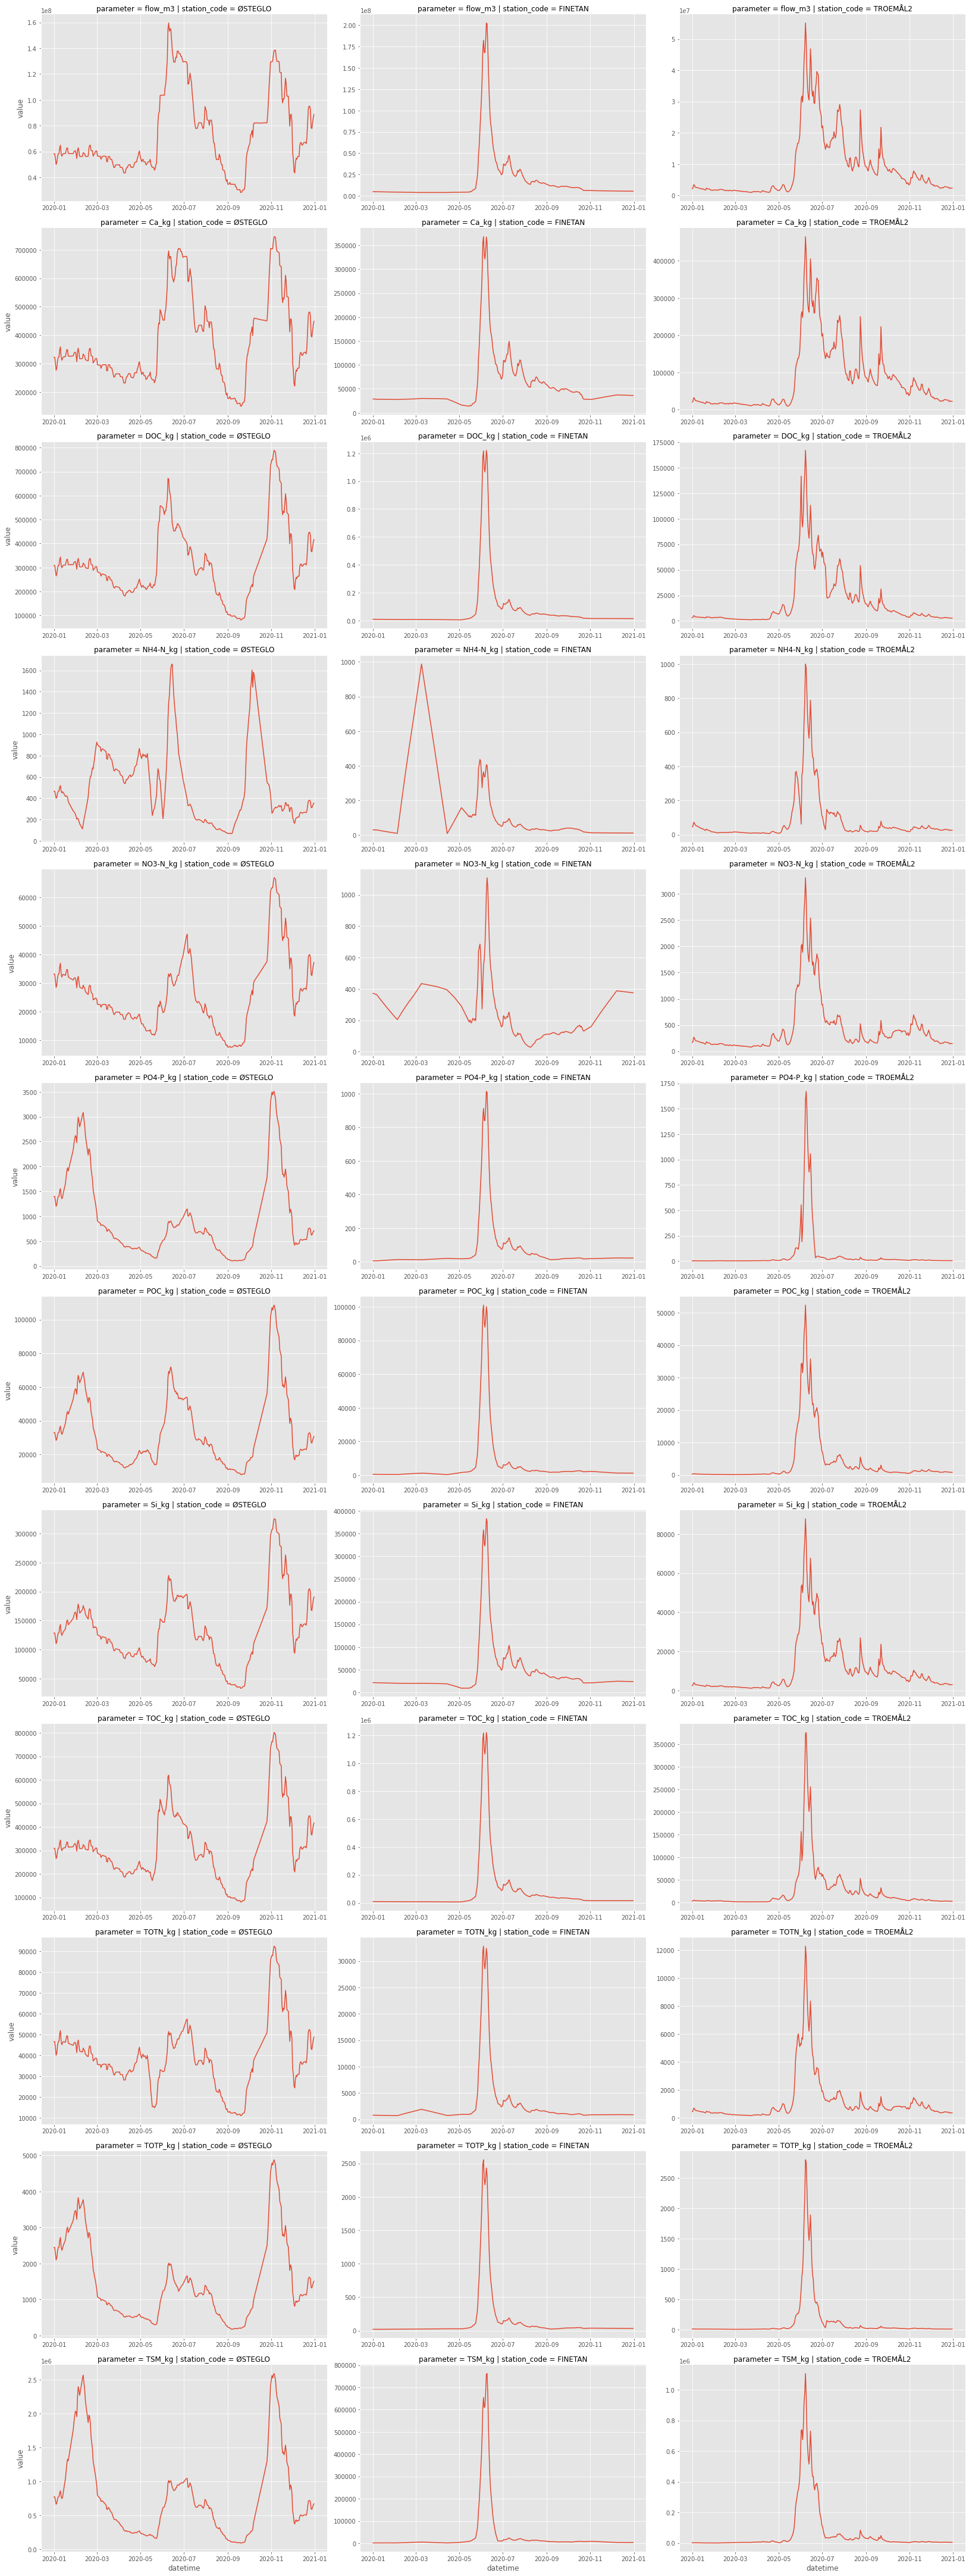

In [14]:
# Convert to long format and plot
df_long = flux_df.copy()
del df_long["station_id"]
df_long = df_long.melt(id_vars=["station_code", "datetime"], var_name="parameter")
sn.relplot(
    data=df_long,
    x="datetime",
    y="value",
    row="parameter",
    col="station_code",
    kind="line",
    aspect=1.5,
    facet_kws={"sharey": False, "sharex": False},
)